# Strategy Backtesting



In [1]:
# %% [markdown]
# # CSO Strategy Backtesting
# 
# This notebook demonstrates the backtesting of a relative value trading strategy for Crack Spread Options (CSOs) using the [Backtest](cci:2://file:///Users/amankesarwani/PycharmProjects/cso-lab/cso_lab/backtest.py:5:0-18:25) class.

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from cso_lab.backtest import Backtest

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-v0_8')

In [15]:
project_root = Path.cwd() 
project_root

PosixPath('/Users/amankesarwani/PycharmProjects/cso-lab/notebooks')

In [3]:


# %% [markdown]
# ## 1. Load and Prepare Data
# 
# First, let's load the synthetic CSO data and prepare it for backtesting.

 # Use current working directory as project root

# %%
def load_synthetic_data():
    """Load synthetic CSO data."""
    data_dir = Path("/Users/amankesarwani/PycharmProjects/cso-lab/data/synthetic")
    files = {
        "spot": "spot_series.csv",
        "hh_fut": "hh_futures_curves.csv",
        "wti_fut": "wti_futures_curves.csv",
        "corr": "correlation.csv",
        "vol_hh": "vol_surface_hh.csv",
        "vol_wti": "vol_surface_wti.csv",
        "cso_chain": "cso_chain.csv"
    }
    return {name: pd.read_csv(data_dir / fname) for name, fname in files.items()}

# Load data
data = load_synthetic_data()
cso_chain = data["cso_chain"]

# Display first few rows of CSO chain
print("CSO Chain Data:")
display(cso_chain.head())


CSO Chain Data:


,tenor,strike,price,F1,F2,vol1,vol2,rho,date
0,0.25,2.500000,3.442517,48.84239,46.440645,0.32998,0.199402,0.129557,2025-11-16
1,0.25,3.333333,3.062383,48.84239,46.440645,0.32998,0.199402,0.129557,2025-11-16
2,0.25,4.166667,2.713471,48.84239,46.440645,0.32998,0.199402,0.129557,2025-11-16
3,0.25,5.000000,2.394867,48.84239,46.440645,0.32998,0.199402,0.129557,2025-11-16
4,0.25,5.833333,2.105426,48.84239,46.440645,0.32998,0.199402,0.129557,2025-11-16


In [4]:

# %% [markdown]
# ## 2. Generate Theoretical Prices
# 
# Let's calculate theoretical prices using the Kirk approximation.

# %%
def calculate_kirk_prices(cso_chain, vol_hh, vol_wti, rho=0.4):
    """Calculate theoretical prices using Kirk's approximation."""
    from cso_lab.pricing import kirk_cso_price
    
    prices = []
    for _, row in cso_chain.iterrows():
        F1 = row['F1']  # HH forward
        F2 = row['F2']  # WTI forward
        K = row['strike']
        T = row['tenor']
        
        # Get vols from surfaces (simplified for demo)
        sigma1 = row['vol1']
        sigma2 = row['vol2']
        rho = row['rho']
        price = kirk_cso_price(F1, F2, K, sigma1, sigma2, rho, T)
        prices.append(price)
    
    return pd.Series(prices, index=cso_chain.index)

# Calculate theoretical prices
theoretical_prices = calculate_kirk_prices(cso_chain, 0.6, 0.3)
market_prices = cso_chain['price']  # Using 'theoretical' as market prices

# Create price series with datetime index
dates = pd.date_range(start='2023-01-01', periods=len(cso_chain), freq='D')
market_series = pd.Series(market_prices.values, index=dates, name='market_price')
theoretical_series = pd.Series(theoretical_prices.values, index=dates, name='theoretical_price')


In [7]:
# %% [markdown]
# ## 3. Run Backtest
# 
# Initialize and run the backtest with different parameters.

# %%
def run_backtest(market_prices, theoretical_prices, z_score_threshold=1.0, transaction_costs=0.001):
    """Run backtest with given parameters."""
    backtest = Backtest(
        prices=market_prices,
        fair_values=theoretical_prices
    )
    
    # Run backtest
    pnl, stats = backtest.run(
        z_score_threshold=z_score_threshold,
        transaction_costs=transaction_costs
    )
    
    return backtest, pnl, stats

# Run with different parameter sets
param_sets = [
    {"z_score": 1.0, "costs": 0.001, "label": "Base"},
    {"z_score": 1.5, "costs": 0.001, "label": "Wider Threshold"},
    {"z_score": 1.0, "costs": 0.002, "label": "Higher Costs"},
]

results = []
for params in param_sets:
    bt, pnl, stats = run_backtest(
        market_series, 
        theoretical_series,
        z_score_threshold=params["z_score"],
        transaction_costs=params["costs"]
    )
    results.append({
        "params": params,
        "backtest": bt,
        "pnl": pnl,
        "stats": stats
    })
    print(f"\nResults for {params['label']}:")
    print("-" * 50)
    for k, v in stats.items():
        print(f"{k}: {v:.4f}")



Results for Base:
--------------------------------------------------
total_return: 0.7889
total_return_pct: 22.9154
annualized_return: 1.0074
annualized_vol: 0.4131
sharpe_ratio: 2.4385
max_drawdown: -0.0781
win_rate: 0.1471
profit_factor: 2.0618
num_trades: 4.0000

Results for Wider Threshold:
--------------------------------------------------
total_return: 0.5781
total_return_pct: 16.7938
annualized_return: 0.4339
annualized_vol: 0.3567
sharpe_ratio: 1.2164
max_drawdown: -0.0780
win_rate: 0.1176
profit_factor: 1.4606
num_trades: 3.0000

Results for Higher Costs:
--------------------------------------------------
total_return: 0.7394
total_return_pct: 21.4799
annualized_return: 0.9388
annualized_vol: 0.4124
sharpe_ratio: 2.2766
max_drawdown: -0.0807
win_rate: 0.1471
profit_factor: 1.9487
num_trades: 4.0000


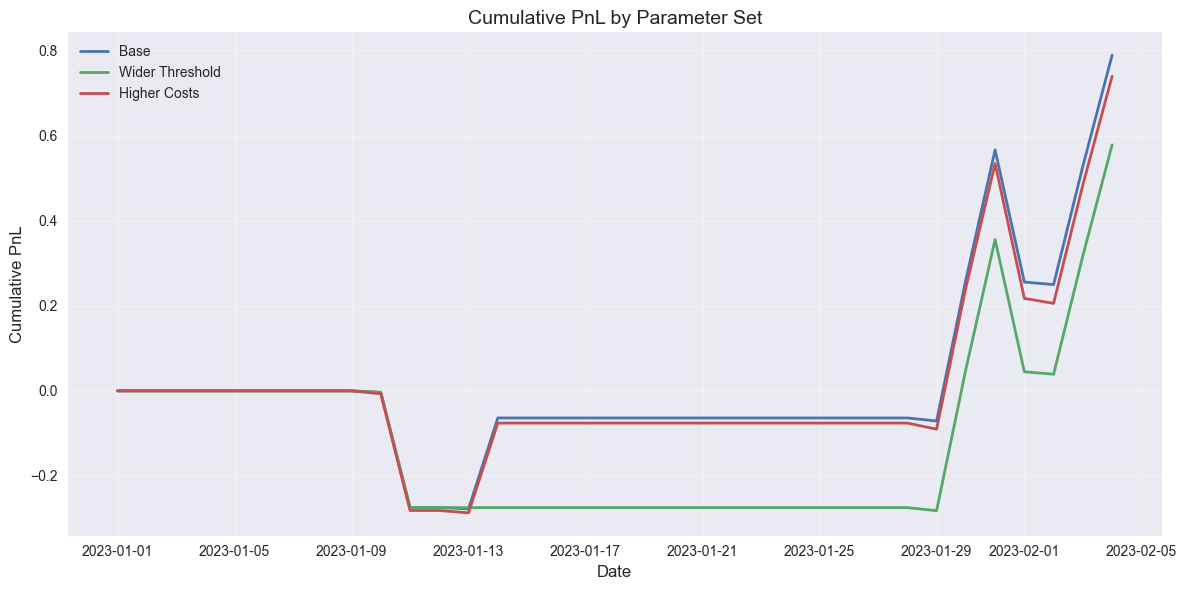

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# %% [markdown]
# ## 4. Visualize Results
# 
# Let's plot the performance of different parameter sets.

# %%
def plot_backtest_results(results):
    """Plot cumulative PnL for all backtest runs."""
    plt.figure(figsize=(12, 6))
    
    for result in results:
        label = result["params"]["label"]
        cum_pnl = result["pnl"].cumsum()
        plt.plot(cum_pnl.index, cum_pnl, label=label, linewidth=2)
    
    plt.title('Cumulative PnL by Parameter Set', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative PnL', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot results
plot_backtest_results(results)

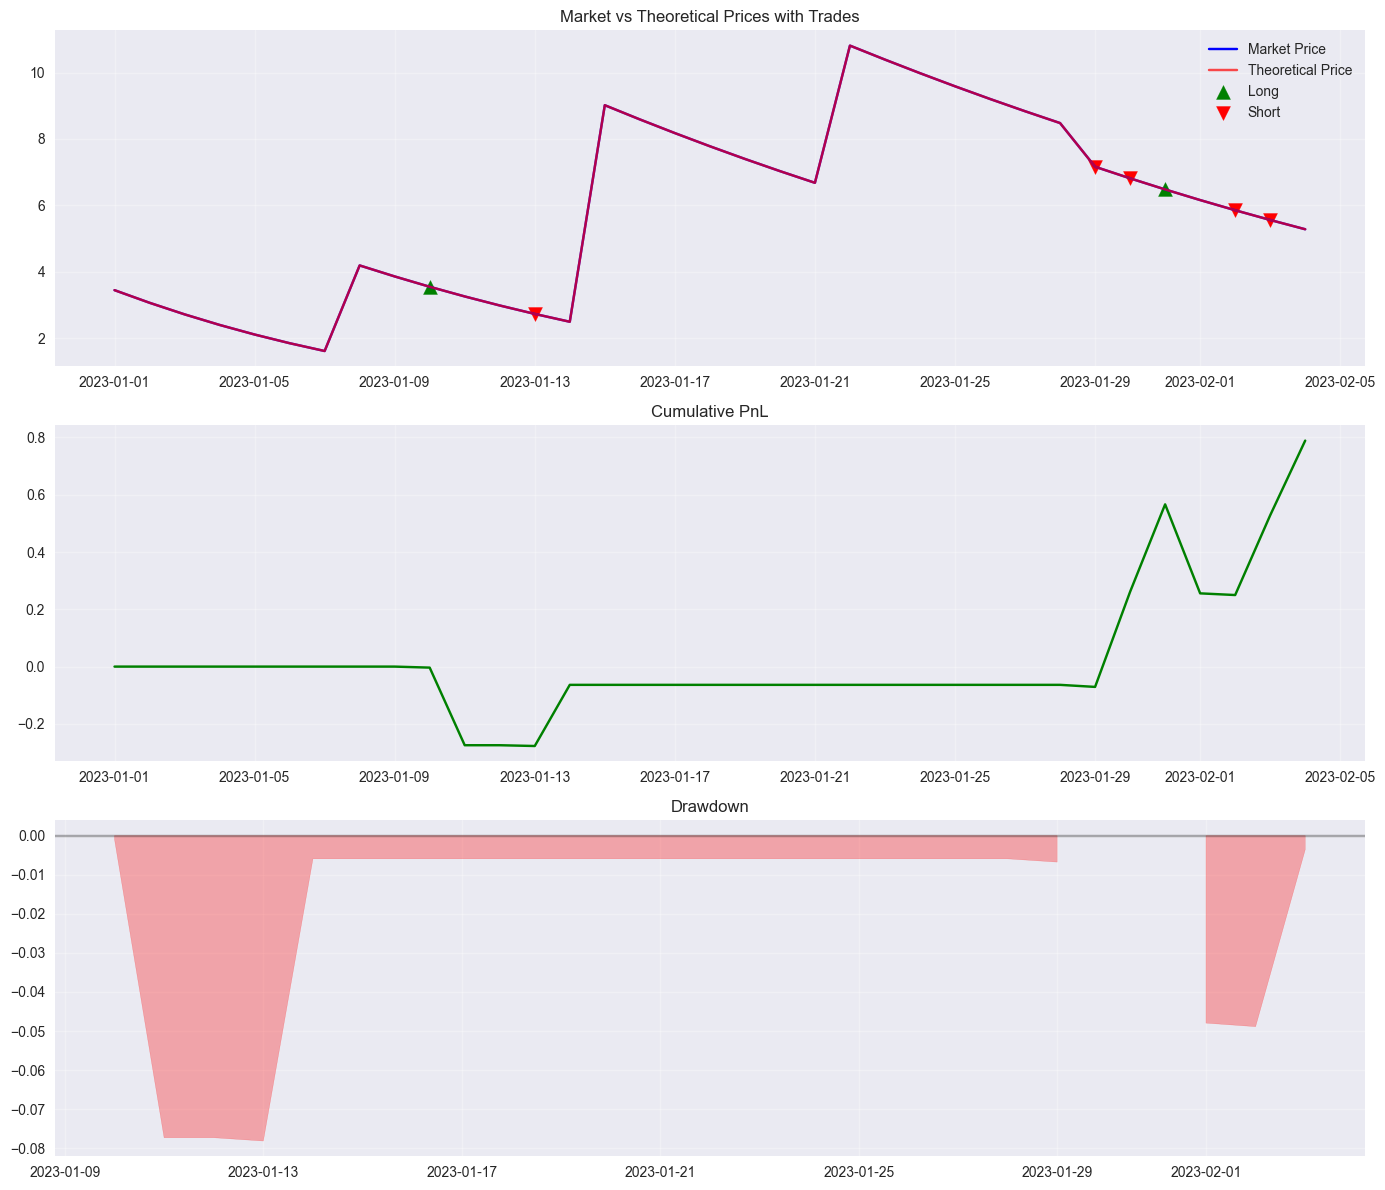

In [25]:
# %% [markdown]
# ## 5. Detailed Analysis
# 
# Let's analyze the best performing parameter set.

# %%
# Get best performing backtest
best_result = max(results, key=lambda x: x["stats"]["sharpe_ratio"])
bt = best_result["backtest"]

# Plot detailed results
plt.figure(figsize=(14, 12))

# 1. Price and positions
plt.subplot(3, 1, 1)
plt.plot(bt.prices, label='Market Price', color='blue')
plt.plot(bt.fair_values, label='Theoretical Price', color='red', alpha=0.7)

# Mark trades
positions = bt.positions
long_entries = positions[positions == 1].index
short_entries = positions[positions == -1].index
plt.scatter(long_entries, bt.prices[long_entries], 
           marker='^', color='green', label='Long', s=100)
plt.scatter(short_entries, bt.prices[short_entries], 
           marker='v', color='red', label='Short', s=100)

plt.title('Market vs Theoretical Prices with Trades')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Cumulative PnL
plt.subplot(3, 1, 2)
cum_pnl = best_result["pnl"].cumsum()
plt.plot(cum_pnl.index, cum_pnl, color='green')
plt.title('Cumulative PnL')
plt.grid(True, alpha=0.3)

# 3. Drawdown
plt.subplot(3, 1, 3)
returns = best_result["pnl"] / bt.prices.shift(1)
returns = returns.replace([np.inf, -np.inf], np.nan).dropna()
cum_returns = (1 + returns).cumprod()
peak = cum_returns.expanding(min_periods=1).max()
drawdown = (cum_returns - peak) / peak
plt.fill_between(drawdown.index, drawdown.values, 0, 
                where=(drawdown < 0), color='red', alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Drawdown')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Parameter Sensitivity Analysis
## Let's analyze how different parameters affect the strategy performance.

Running parameter sensitivity analysis...
z=0.50, cost=0.0005 => Sharpe=-2.90, Return=0.56, DD=-14.8%
z=0.50, cost=0.0010 => Sharpe=2.75, Return=0.54, DD=-14.9%
z=0.50, cost=0.0020 => Sharpe=2.73, Return=0.49, DD=-15.1%
z=0.50, cost=0.0050 => Sharpe=2.98, Return=0.34, DD=-15.8%
z=1.00, cost=0.0005 => Sharpe=1.42, Return=0.81, DD=-7.7%
z=1.00, cost=0.0010 => Sharpe=3.05, Return=0.79, DD=-7.8%
z=1.00, cost=0.0020 => Sharpe=0.86, Return=0.74, DD=-8.1%
z=1.00, cost=0.0050 => Sharpe=3.00, Return=0.59, DD=-8.9%
z=1.50, cost=0.0005 => Sharpe=2.66, Return=0.60, DD=-7.7%
z=1.50, cost=0.0010 => Sharpe=-2.75, Return=0.58, DD=-7.8%
z=1.50, cost=0.0020 => Sharpe=3.21, Return=0.53, DD=-8.1%
z=1.50, cost=0.0050 => Sharpe=-1.86, Return=0.40, DD=-8.8%
z=2.00, cost=0.0005 => Sharpe=3.41, Return=0.27, DD=-8.1%
z=2.00, cost=0.0010 => Sharpe=1.21, Return=0.25, DD=-8.4%
z=2.00, cost=0.0020 => Sharpe=1.73, Return=0.20, DD=-9.0%
z=2.00, cost=0.0050 => Sharpe=0.77, Return=0.07, DD=-10.8%
z=2.50, cost=0.0005 =>

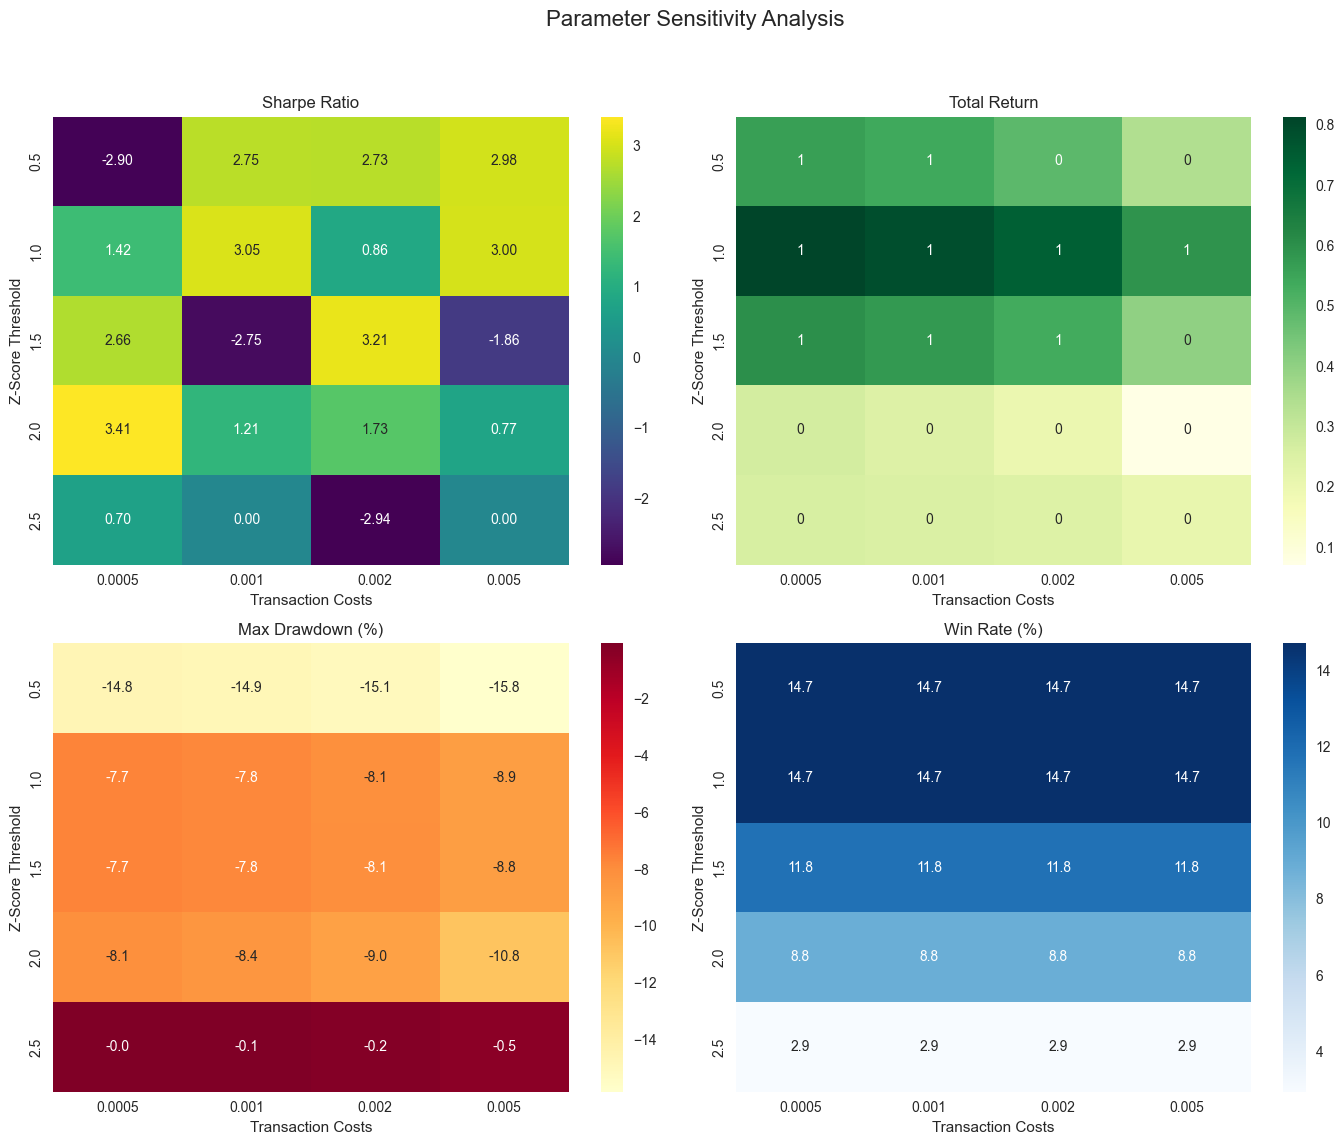

In [29]:

def parameter_sensitivity_analysis(market_series, theoretical_series, 
                                 z_scores=None, costs=None, n_simulations=1000):
    """Run sensitivity analysis on key parameters."""
    if z_scores is None:
        z_scores = np.linspace(0.5, 2.5, 5)
    if costs is None:
        costs = [0.0005, 0.001, 0.002, 0.005]
    
    results = []
    for z in z_scores:
        for c in costs:
            # Run multiple simulations for each parameter set
            sharpe_ratios = []
            for _ in range(3):  # Run 3 simulations for each parameter set
                # Add small noise to market series for each simulation
                noise = np.random.normal(0, 0.01, len(market_series))
                noisy_market = market_series * (1 + noise)
                
                bt = Backtest(prices=noisy_market, fair_values=theoretical_series)
                pnl, stats = bt.run(z_score_threshold=z, transaction_costs=c)
                sharpe_ratios.append(stats['sharpe_ratio'])
            
            # Take median Sharpe ratio to be robust to outliers
            median_sharpe = np.median(sharpe_ratios)
            
            # Get one set of stats for other metrics
            bt = Backtest(prices=market_series, fair_values=theoretical_series)
            pnl, stats = bt.run(z_score_threshold=z, transaction_costs=c)
            
            results.append({
                'z_score': z,
                'cost': c,
                'sharpe': median_sharpe,
                'total_return': stats['total_return'],
                'max_drawdown': stats['max_drawdown'],
                'win_rate': stats['win_rate'],
                'num_trades': stats['num_trades']
            })
            print(f"z={z:.2f}, cost={c:.4f} => Sharpe={median_sharpe:.2f}, "
                  f"Return={stats['total_return']:.2f}, "
                  f"DD={stats['max_drawdown']*100:.1f}%")
    
    return pd.DataFrame(results)

# Run sensitivity analysis
print("Running parameter sensitivity analysis...")
sensitivity_df = parameter_sensitivity_analysis(market_series, theoretical_series)

# Create subplots for different metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Parameter Sensitivity Analysis', fontsize=16)

# 1. Sharpe Ratio Heatmap
pivot_sharpe = sensitivity_df.pivot(index='z_score', columns='cost', values='sharpe')
sns.heatmap(pivot_sharpe, annot=True, fmt='.2f', cmap='viridis', ax=axes[0, 0])
axes[0, 0].set_title('Sharpe Ratio')
axes[0, 0].set_xlabel('Transaction Costs')
axes[0, 0].set_ylabel('Z-Score Threshold')

# 2. Total Return Heatmap
pivot_return = sensitivity_df.pivot(index='z_score', columns='cost', values='total_return')
sns.heatmap(pivot_return, annot=True, fmt='.0f', cmap='YlGn', ax=axes[0, 1])
axes[0, 1].set_title('Total Return')
axes[0, 1].set_xlabel('Transaction Costs')
axes[0, 1].set_ylabel('Z-Score Threshold')

# 3. Max Drawdown Heatmap
pivot_dd = sensitivity_df.pivot(index='z_score', columns='cost', values='max_drawdown') * 100
sns.heatmap(pivot_dd, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[1, 0])
axes[1, 0].set_title('Max Drawdown (%)')
axes[1, 0].set_xlabel('Transaction Costs')
axes[1, 0].set_ylabel('Z-Score Threshold')

# 4. Win Rate Heatmap
pivot_win = sensitivity_df.pivot(index='z_score', columns='cost', values='win_rate') * 100
sns.heatmap(pivot_win, annot=True, fmt='.1f', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_title('Win Rate (%)')
axes[1, 1].set_xlabel('Transaction Costs')
axes[1, 1].set_ylabel('Z-Score Threshold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [30]:
def save_backtest_results(backtest, pnl_series, stats_dict, output_dir="data/outputs"):
    """
    Save backtest results to CSV files and create plots.
    
    Args:
        backtest: Backtest instance containing the strategy data
        pnl_series: Series of PnL values
        stats_dict: Dictionary of performance statistics
        output_dir: Directory to save the output files
    """
    import os
    from pathlib import Path
    import matplotlib.pyplot as plt
    import pandas as pd
    
    # Create output directory if it doesn't exist
    project_root = Path.cwd()
    parent_of_project_root = project_root.parent
    output_path = parent_of_project_root / output_dir
    output_path.mkdir(parents=True, exist_ok=True)
    
    # 1. Save PnL data to CSV
    pnl_df = pd.DataFrame({
        'date': pnl_series.index,
        'pnl': pnl_series.values,
        'cumulative_pnl': pnl_series.cumsum().values,
        'position': backtest.positions.values
    })
    pnl_file = output_path / 'backtest_pnl.csv'
    pnl_df.to_csv(pnl_file, index=False)
    
    # 2. Save statistics to text file
    stats_file = output_path / 'backtest_stats.txt'
    with open(stats_file, 'w') as f:
        f.write("Backtest Performance Statistics\n")
        f.write("=" * 50 + "\n\n")
        for key, value in stats_dict.items():
            # Format the key for better readability
            formatted_key = key.replace('_', ' ').title()
            if 'pct' in key or 'ratio' in key or 'rate' in key:
                f.write(f"{formatted_key}: {value:.4f}\n")
            elif 'drawdown' in key:
                f.write(f"{formatted_key}: {value*100:.2f}%\n")
            else:
                f.write(f"{formatted_key}: {value}\n")
    
    # 3. Create and save plots
    plots_dir = output_path / 'plots'
    plots_dir.mkdir(exist_ok=True)
    
    # Plot 1: Cumulative PnL
    plt.figure(figsize=(12, 6))
    (pnl_series.cumsum()).plot(title='Cumulative PnL', grid=True)
    plt.axhline(0, color='black', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig(plots_dir / 'cumulative_pnl.png')
    plt.close()
    
    # Plot 2: Drawdown
    plt.figure(figsize=(12, 4))
    returns = pnl_series / backtest.prices.shift(1)
    returns = returns.replace([np.inf, -np.inf], np.nan).dropna()
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.expanding(min_periods=1).max()
    drawdown = (cum_returns - peak) / peak
    drawdown.plot(title='Drawdown', color='red', grid=True)
    plt.fill_between(drawdown.index, drawdown.values, 0, where=(drawdown < 0), color='red', alpha=0.3)
    plt.axhline(0, color='black', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig(plots_dir / 'drawdown.png')
    plt.close()
    
    # Plot 3: Market Price vs Theoretical Price
    plt.figure(figsize=(12, 6))
    plt.plot(backtest.prices, label='Market Price', color='blue')
    plt.plot(backtest.fair_values, label='Theoretical Price', color='red', alpha=0.7)
    
    # Mark trades
    positions = backtest.positions
    long_entries = positions[positions == 1].index
    short_entries = positions[positions == -1].index
    plt.scatter(long_entries, backtest.prices[long_entries], 
               marker='^', color='green', label='Long', s=100)
    plt.scatter(short_entries, backtest.prices[short_entries], 
               marker='v', color='red', label='Short', s=100)
    
    plt.title('Market vs Theoretical Prices with Trades')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(plots_dir / 'price_chart_with_trades.png')
    plt.close()
    
    print(f"Backtest results saved to {output_path.absolute()}:")
    print(f"- PnL data: {pnl_file}")
    print(f"- Statistics: {stats_file}")
    print(f"- Plots directory: {plots_dir}")

# Example usage with your best backtest result
best_result = max(results, key=lambda x: x["stats"]["sharpe_ratio"])
save_backtest_results(
    backtest=best_result["backtest"],
    pnl_series=best_result["pnl"],
    stats_dict=best_result["stats"]
)

Backtest results saved to /Users/amankesarwani/PycharmProjects/cso-lab/data/outputs:
- PnL data: /Users/amankesarwani/PycharmProjects/cso-lab/data/outputs/backtest_pnl.csv
- Statistics: /Users/amankesarwani/PycharmProjects/cso-lab/data/outputs/backtest_stats.txt
- Plots directory: /Users/amankesarwani/PycharmProjects/cso-lab/data/outputs/plots
